# Neural Style Transfer
The idea behind this project is to make a program repaint a content image in the style of a style image.  
let's say I want to have this picture of this addorable gentelman to be repainted in the style of that other image.  
<img src="images/content.jpg" width="300px" style="float: left; margin-right: 30px;" />
<img src="images/style.png" width="300px" style="float: left;" />  



# Plan of attack
This is not a very straight forward problem so let me break it down for you.  
We need to extract features out of these images, we don't want to have the exact pixel values in them, we just need the features.  
To extract these features we could ( and will ) use a pretrained CNN to encode these images into feature maps.  
Then we need to figure out a way to mathematically model the style of the style image.  
Then we need to define a function that models the content loss (a metric that measures how different the image in hand is from the content image)
Then we need to define a function that models the style loss (a metric that measures how different the style of the image in hand is from the style of the style image)

**To sum up**
* Use a pretrained CNN to convert images to feature maps
* Define a function to model the style of an image given its feature map
* Define a function to calculate the loss $ min (J), \quad J = \alpha J_{content} + \beta J_{style} $
* **OPTIONAL** get rid of noise

**NOTE**
> The optimization variable this time is not going to be the weights of the CNN, those will remain unchanged
> it will rather be the pixel data of the target image that you want to create.

In [1]:
## importing modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
import PIL.Image
from tqdm import tqdm
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

In [2]:
def load_img(path_to_img):
    max_dim = 512
    # read file
    img = tf.io.read_file(path_to_img)
    # decode with three channels RGB
    img = tf.image.decode_image(img, channels=3)
    # convert the datatype of tensor to float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # get the size of the image as float32
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    # get the longer dimension
    long_dim = max(shape)
    # define a scaling factor
    scale = max_dim / long_dim
    # scale the image by that factor and save the new shape as int32
    # this keeps the aspect ratio
    new_shape = tf.cast(shape * scale, tf.int32)
    # resize the image to the new shape
    img = tf.image.resize(img, new_shape)
    # make it a batch
    img = img[tf.newaxis, :]
    return img

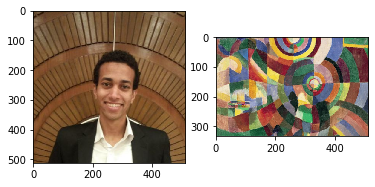

In [3]:
# let's load the images
content_image = load_img("images/avatar.jpg")
style_image = load_img("images/style.png")

plt.subplot(1, 2, 1)
plt.imshow(content_image[0])

plt.subplot(1, 2, 2)
plt.imshow(style_image[0])

## Getting a pretrained CNN
The `tensorflow.keras.applications` module has a lot of powerful CNNs that we can use.  
I'll be using the VGG19 network in this notebook but feel free to use whatever you want.

In [4]:
vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
# The top is the last layer in the network, this is used for classification so we don't need it

In [5]:
# the feature maps are extracted from the convolutional layers of the model
# let's find out how they're named
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Now let's take some of those names and store them in two lists
* One will be hold content layers from which we extract feature maps to calculate the content loss
* The other will hold the style layers form which we extract feature maps to calculate the style loss

In [6]:
# you can change these if you want, playing around is never bad ;)
content_layers = ["block5_conv4"]
style_layers = [
    "block1_conv1",
    "block2_conv2",
    "block3_conv2",
    "block4_conv3",
    "block5_conv3",
]
no_content = len(style_layers)
no_style = len(content_layers)

Now let's define a model which has the inputs of the vgg model and outputs of those layers

In [7]:
outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
extractor = tf.keras.Model(inputs=vgg.inputs, outputs=outputs)
extractor.trainable = False

In [8]:
# let's take it for a spin
outputs = extractor(content_image)
len(outputs)

6

### Nice
We now have six output for six layers, five for style and one for content.  
Getting feature maps ... check.


## The Gram matrix
We need a way to model the style, the gram matrix does that job well.  
First you need to understand how the style is defined, it is defined as the corelation between features.  
The gram matrix calculates just that and implementing it is very easy.  
For any layer $ l $ with output $ F(x) $ with dimensions $ i, j, c $ also modeled as $ i, j, d $, The gram matrix G is defined as: 
  
  
$$ G_{cd}^l = \frac{\sum_{ij} F_{ij}^l(x) * F_{ij}^l(x)}{IJ} $$  

You can calculate that in tensorflow using the beautiful [`tensorflow.linalg.einsum`](https://www.tensorflow.org/api_docs/python/tf/einsum) function

In [9]:
def gram_matrix(input_tensor):
    # the b dimension is just the batch, don't worry about it
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations
    

In [10]:
# the first layer in the outputs is block1_conv1
# this one has output shape of (None, None, None, 64)
# its gram matrix should have shape (None, 64, 64) with none being the batches (just 1)
g = gram_matrix(outputs[0])
g.shape

TensorShape([1, 64, 64])

### Looking good
Now we can get the style of any image.  
Let's dive into the next step.  
> **BUT** before we continue let's define a class that outputs the style and content encodings of any image just to make our lives easier when we get to the loss functions

In [11]:
class StyleContentExtractor(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentExtractor, self).__init__()
        outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
        self.model = tf.keras.Model(inputs=vgg.inputs, outputs=outputs)
        self.model.trainable = False
        
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.no_style_layers = len(style_layers)
        
    def call(self, inputs):
        inputs = inputs*255.
        inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.model(inputs)
        
        content_outputs = outputs[self.no_style_layers:]
        style_outputs = [gram_matrix(out) for out in outputs[:self.no_style_layers]]
        
        content_dict = {name: val for name, val in zip(self.content_layers, content_outputs)}
        style_dict = {name: val for name, val in zip(self.style_layers, style_outputs)}
        
        return {"style": style_dict, "content": content_dict}
        
        
extractor = StyleContentExtractor(style_layers, content_layers)

Let's now extract the target content and target styles so we can use them in our loss function.  
let's also set a weight for each loss $ \alpha $ and $ \beta $ where $$ J = \alpha J_{content} + \beta J_{style} $$

In [12]:
content_target = extractor(content_image)["content"]
style_target = extractor(style_image)["style"]
alpha = 1e4
beta = 1e-2

## defining a loss function
Now we need something to optimize, don't we?  
Let's define the loss functions $ J_{content} $ and $ J_{style} $
$$ J_{content} = \frac{(C-O)^2}{C*H*W} \quad \quad J_{style} = \frac{(Gram(S)-Gram(O))^2}{C*H*W} $$

In [13]:
def content_style_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_target[name])**2) 
                           for name in style_outputs.keys()])
    
    style_loss *= beta / no_style
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_target[name])**2) 
                           for name in content_outputs.keys()])
    
    content_loss *= alpha / no_content
    
    return content_loss + style_loss
    

In [14]:
# let'd define the variable for which we want to optimize the loss ( O )
# this is the generated image
# initially, it has the exact contents of the content image
image = tf.Variable(content_image)

### Almost done
Now we need to define an optimizer.  
We also need to define a function that we can call in the tensorflow graph to take a gradient descent step.  
In order to be able to call the function in the tensorflow graph you need to decorate it with the [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function) decorator

In [15]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# we need to make sure the tensor values remain between 0 and 1
# let's clip its values
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


@tf.function()
def step(img):
    # this context manager is used to calculate the gradient
    with tf.GradientTape() as tape:
        outputs = extractor(img)
        loss = content_style_loss(outputs)

    grad = tape.gradient(loss, img)
    opt.apply_gradients([(grad, img)])
    img.assign(clip_0_1(img))

In [16]:
# What we'll get is a tensor having our information.
# let's write a function that turns it into an image
def tensor_to_image(tensor):
    # tensor images are normalized so denormalize them
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [17]:
# let's run a few steps and see what we've got
for _ in tqdm(range(40)):
    step(image)

100%|██████████| 40/40 [05:11<00:00,  7.80s/it]


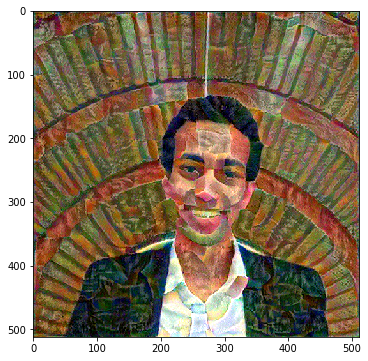

In [18]:
out = tensor_to_image(image)
plt.figure(figsize=(6, 6))
plt.imshow(out)

### hmmmmm!
It's picking up the style, but it's a bit noisy.  
I wonder if we can define a loss function for noise and add that to our loss function so we can minimize it.  
Well, my friend, you can.  
let's do that now.  
  
I'll define noise as fast changes or edges both horizontal and vertical.  
Let's see what that looks like

In [19]:
diff = 1
def high_pass_x_y(image):
    x_var = image[:,:,diff:,:] - image[:,:,:-diff,:] # fast variations on the x axis
    y_var = image[:,diff:,:,:] - image[:,:-diff,:,:] # fast variations on the y axis

    return x_var, y_var


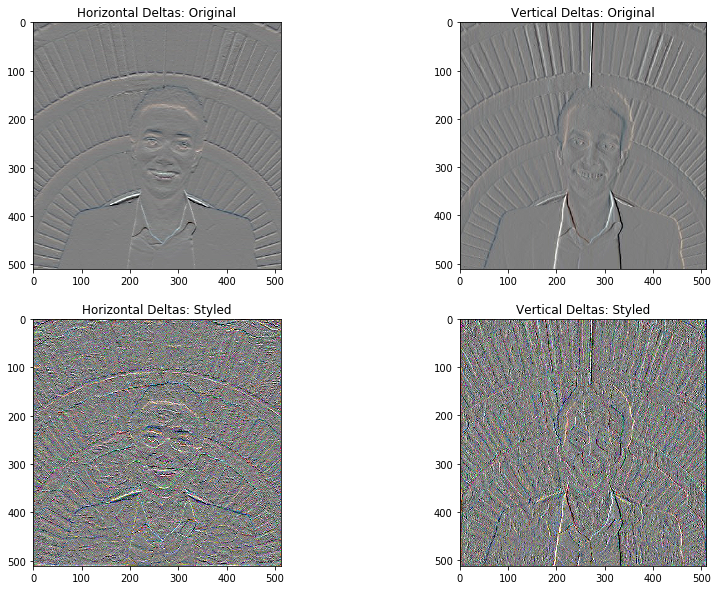

In [20]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.title("Horizontal Deltas: Original")
plt.imshow(clip_0_1(2*y_deltas[0]+0.5))

plt.subplot(2,2,2)
plt.title("Vertical Deltas: Original")
plt.imshow(clip_0_1(2*x_deltas[0]+0.5))

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
plt.title("Horizontal Deltas: Styled")
plt.imshow(clip_0_1(2*y_deltas[0]+0.5))

plt.subplot(2,2,4)
plt.title("Vertical Deltas: Styled")
plt.imshow(clip_0_1(2*x_deltas[0]+0.5))

Obviously the styled image has much more high frequency changes.  
Let's get rid of those by adding them to the loss function

In [21]:
noise_weight = 1e3
def content_style_noise_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_target[name])**2) 
                           for name in style_outputs.keys()])
    
    style_loss *= beta / no_style
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_target[name])**2) 
                           for name in content_outputs.keys()])
    
    content_loss *= alpha / no_content
    
    x_deltas, y_deltas = high_pass_x_y(image)
    noise_loss = tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))
    
    noise_loss *= noise_weight
    
    return content_loss + style_loss + noise_loss

In [22]:
# let's do it again
@tf.function()
def step(img):
    # this context manager is used to calculate the gradient
    with tf.GradientTape() as tape:
        outputs = extractor(img)
        loss = content_style_noise_loss(outputs) # added noise

    grad = tape.gradient(loss, img)
    opt.apply_gradients([(grad, img)])
    img.assign(clip_0_1(img))

In [23]:
image = tf.Variable(content_image)
for _ in tqdm(range(40)):
    step(image)

100%|██████████| 40/40 [04:43<00:00,  7.08s/it]


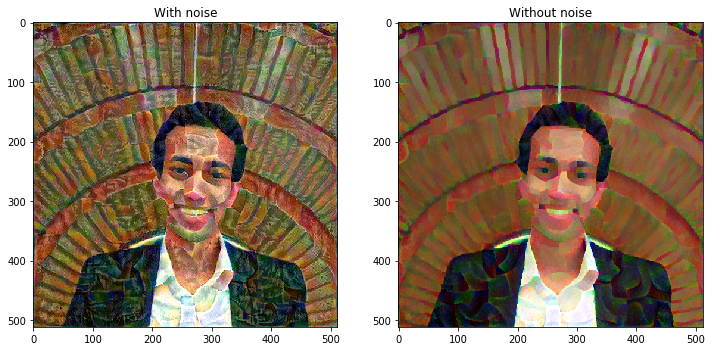

In [24]:
# ready? even if not, here we go
out_filtered = tensor_to_image(image)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("With noise")
plt.imshow(out)

plt.subplot(1, 2, 2)
plt.title("Without noise")
plt.imshow(out_filtered)

## Awesome
That's it for that project
I encourage you to play around with the following and see if you get different results
* The model
* The content and style layers
* The content, style and noise loss weights

I would appreciate if you share interesting results with me.  
Have an awesome day!

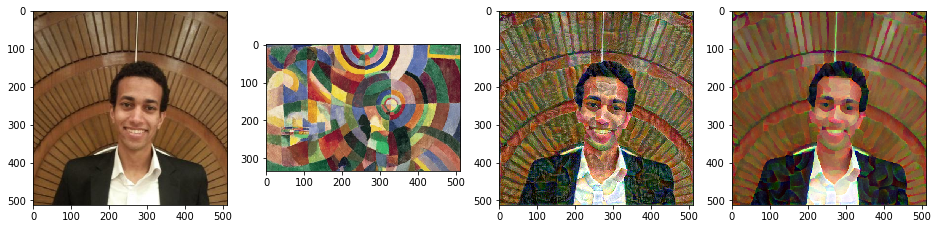

In [25]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(content_image[0])

plt.subplot(1, 4, 2)
plt.imshow(style_image[0])

plt.subplot(1, 4, 3)
plt.imshow(out)

plt.subplot(1, 4, 4)
plt.imshow(out_filtered)
